# **SMS SPAM CLASSIFIER**



*   The goal is to build a machine learning model that can *accurately classify new SMS messages as spam or not spam based on the extracted features*.
*   Kaggle dataset link named as **SMS Spam Collection** - https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
*   The **SMS Spam Collection** is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of *5,574 messages*, tagged acording being *ham (legitimate) or spam*.
The files contain one message per line.
*   Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.



## **Importing the libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split #evaluating the model
from sklearn.preprocessing import LabelEncoder #for encoding label
from sklearn.feature_extraction.text import TfidfVectorizer  #for converting string to feature vector i.e.,numeric for ml model
from sklearn.feature_extraction.text import CountVectorizer  #for token count
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
import nltk #natural language tool kit
from collections import Counter

## **Data Collection**

In [2]:
#loading the data from csv file to a pandas dataframe
encoding='latin1'  #latin1 is a character encoding that is commonly used for data that contains characters from Western European languages
raw_mail_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sms-spam-classifier/spam.csv',encoding=encoding)

In [3]:
print(raw_mail_data)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will Ì_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


In [4]:
raw_mail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## **Data Cleaning**

<Axes: >

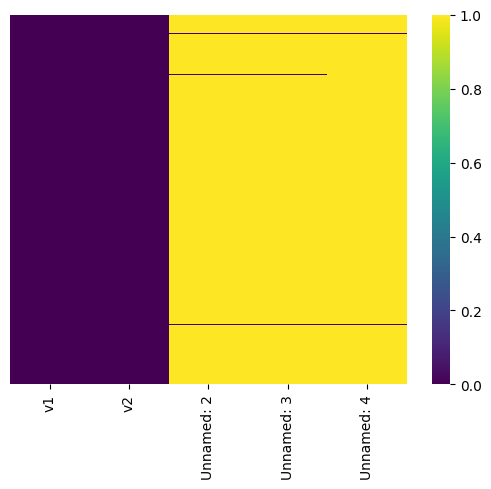

In [5]:
sns.heatmap(raw_mail_data.isnull(), yticklabels = False, cbar = True, cmap = 'viridis')
# cbar : boolean, optional: Whether to draw a colorbar.
# new matplotlib default colormap (“viridis”)

In [6]:
 #droping last 3 rows bcoz not containing essential details
 #inplace=True means working in same file,we are not making copy
raw_mail_data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [7]:
raw_mail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
raw_mail_data.rename(columns={'v1':'type','v2':'text'},inplace=True)  #renaming both column name into type and text
raw_mail_data.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
raw_mail_data['type']=LabelEncoder().fit_transform(raw_mail_data['type'])  #assigning ham->0 and spam->1

In [10]:
raw_mail_data.head()

,type,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
#checking missing values
raw_mail_data.isnull().sum()

type    0
text    0
dtype: int64

In [12]:
#check duplicate values
raw_mail_data.duplicated().sum()

403

In [13]:
#removing duplicates and note-> keep='first' means that when there are duplicate rows in a DataFrame, the first occurrence of each duplicate row will be kept and all subsequent occurrences will be dropped.
raw_mail_data=raw_mail_data.drop_duplicates(keep='first')

In [14]:
raw_mail_data.duplicated().sum()

0

In [15]:
raw_mail_data.shape

(5169, 2)

## **Exploratory Data Analysis**

<ipython-input-16-e5df182620c4>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'type', data =raw_mail_data,palette = 'RdBu_r')


<Axes: xlabel='type', ylabel='count'>

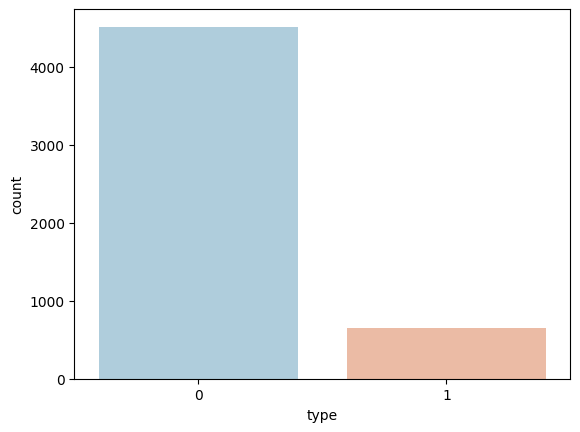

In [16]:
sns.countplot(x = 'type', data =raw_mail_data,palette = 'RdBu_r')

In [17]:
raw_mail_data['type'].value_counts()   #number of hams and spams

0    4516
1     653
Name: type, dtype: int64

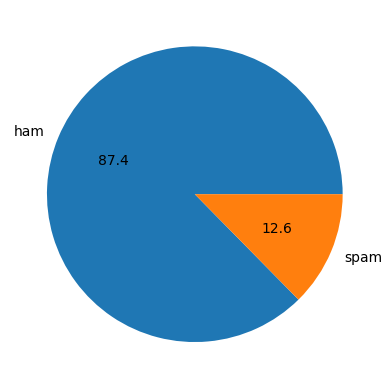

In [18]:
plt.pie(raw_mail_data['type'].value_counts() ,labels=['ham','spam'],autopct="%0.1f")
plt.show()

In [19]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
raw_mail_data['num_characters']=raw_mail_data['text'].apply(len) #for number of characters present in text
raw_mail_data['num_words']=raw_mail_data['text'].apply(lambda x:len(nltk.word_tokenize(x)))  #for number of words present in text
raw_mail_data['num_sentence']=raw_mail_data['text'].apply(lambda x:len(nltk.sent_tokenize(x)))  #for number of sentence present in text
raw_mail_data.head()

,type,text,num_characters,num_words,num_sentence
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [21]:
raw_mail_data[raw_mail_data['type']==0][['num_characters','num_words','num_sentence']].describe()  #for ham sms

,num_characters,num_words,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [22]:
raw_mail_data[raw_mail_data['type']==1][['num_characters','num_words','num_sentence']].describe()  #for spam mail

,num_characters,num_words,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


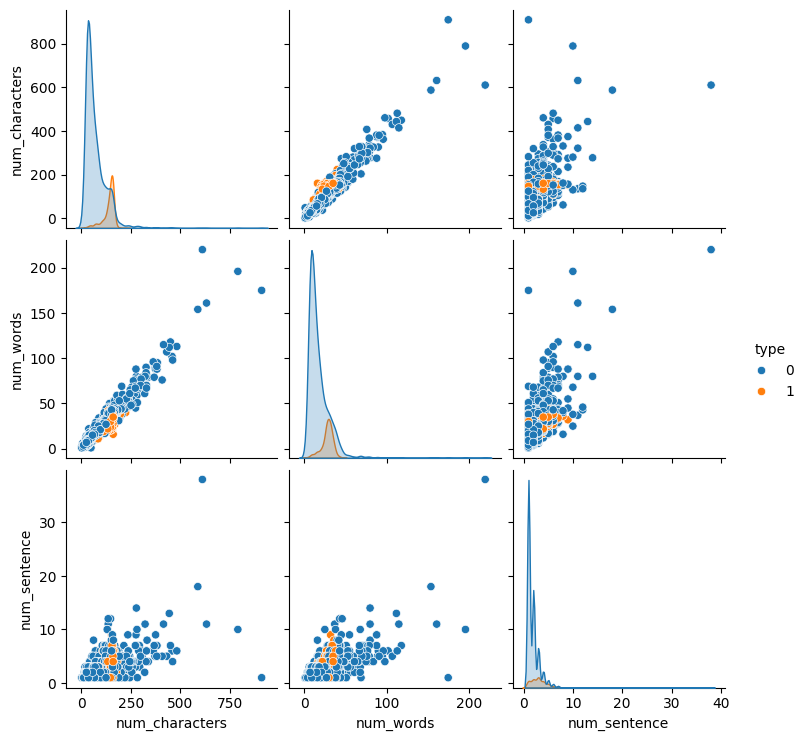

In [23]:
sns.pairplot(raw_mail_data,hue='type')

<ipython-input-24-358b04f2f9b9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(raw_mail_data.corr(),annot=True)  #corelation between features and annot means numeric value


<Axes: >

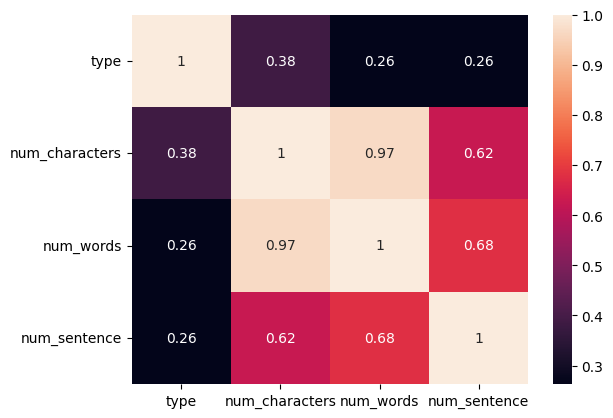

In [24]:
sns.heatmap(raw_mail_data.corr(),annot=True)  #corelation between features and annot means numeric value and here highest is for num_char
#type will be 1 i.e.,spam on increasing num_character

## **Data Preprocessing**

In [25]:
from nltk.corpus import stopwords
nltk.download('stopwords')   #for stopwords
import string    #for getting punctuation
from nltk.stem.porter import PorterStemmer   #for steeming

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
#Steps: the lower case,tokenization,removing special characters,removing stopwords(the,a,an,etc) and punctuation and last stemming("running" can be stemmed to "run")
def transform_text(text):
  text=text.lower()  #for lower case
  text=nltk.word_tokenize(text)   #for tokenize
  store=[]
  for i in text:    #for checking special characters
    if i.isalnum():
      if i not in stopwords.words('english') and i not in string.punctuation:    #for stopwords in english & punctuations
        store.append(PorterStemmer().stem(i))     # for stemming the word

  return ' '.join(store)    #for converting list to string with delimiter

raw_mail_data['text'].apply(transform_text)


0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: text, Length: 5169, dtype: object

In [27]:
raw_mail_data['transformed_text']=raw_mail_data['text'].apply(transform_text)    #creating column for transformed text
raw_mail_data.sample(5)

,type,text,num_characters,num_words,num_sentence,transformed_text
664,0,Yes baby! We can study all the positions of th...,61,15,2,ye babi studi posit kama sutra
3290,0,I'm not smoking while people use \wylie smokes...,85,18,1,smoke peopl use smoke justifi ruin shit
3748,1,Dear Voucher Holder 2 claim your 1st class air...,147,26,2,dear voucher holder 2 claim 1st class airport ...
5362,0,I'm in inside office..still filling forms.don ...,70,15,1,insid offic still fill know leav
2492,0,No drama Pls.i have had enough from you and fa...,245,47,1,drama enough famili struggl hot sun strang rea...


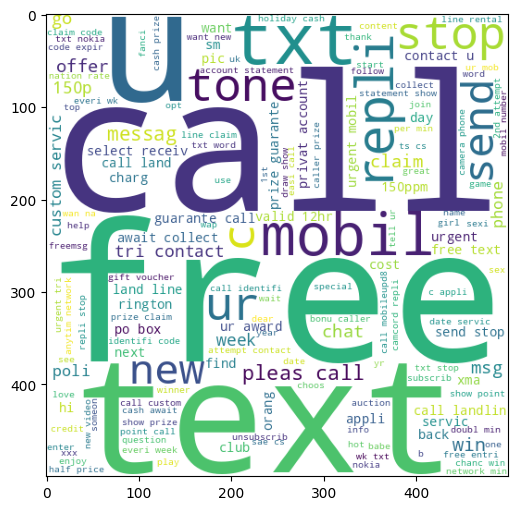

In [28]:
from wordcloud import WordCloud  #for getting words used often
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='white')
#for spam sms
spam_wc=wc.generate(raw_mail_data[raw_mail_data['type']==1]['transformed_text'].str.cat(sep=" "))  #cat for join space
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)    #display data as image

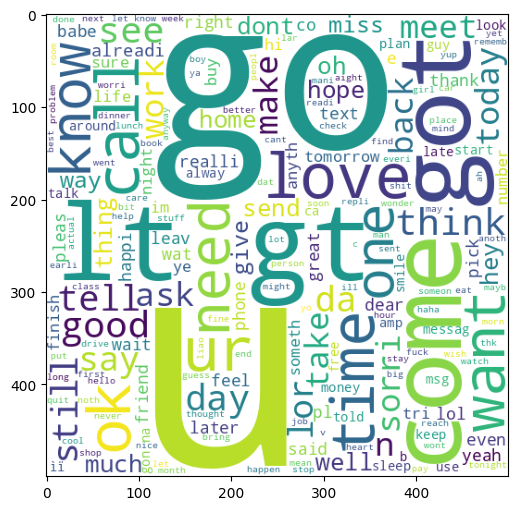

In [29]:
ham_wc=wc.generate(raw_mail_data[raw_mail_data['type']==0]['transformed_text'].str.cat(sep=" "))   #for ham sms
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [30]:
#for checking top 10 word of spam
spam=[]
for i in raw_mail_data[raw_mail_data['type']==1]['transformed_text'].tolist():
  for j in i.split():
    spam.append(j)
pd.DataFrame(Counter(spam).most_common(10))


,0,1
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


In [31]:
#for checking top 10 word of ham
ham=[]
for i in raw_mail_data[raw_mail_data['type']==0]['transformed_text'].tolist():
  for j in i.split():
    ham.append(j)
pd.DataFrame(Counter(ham).most_common(10))

,0,1
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


## **Model Building**



## **1.   Using BoW vectorizer for Naive Bayes Classifier**



In [32]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

cv=CountVectorizer()   #for bag-of-words vectorizer
#Partioning both columns in diff. variables
#feature extracting
X=cv.fit_transform(raw_mail_data['transformed_text']).toarray()      #converting text into numeric type or lets say vector form
print(X)
X.shape

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(5169, 6708)

In [33]:
Y=raw_mail_data['type'].values
Y

array([0, 0, 1, ..., 0, 0, 0])

In [34]:
#tset_size=0.2==20%
#random_state->When the random_state is set to a specific value, the algorithm will always produce the same results given the same input data.
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

In [35]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB   #importing naive bayes libraries
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

#using guassian naive bayes algorithm
trained_model=gnb.fit(X_train,Y_train)
Y_pred=gnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.8800773694390716
Precision: 0.5315315315315315
Confusion Matrix:
 [[792 104]
 [ 20 118]]
Model score: 0.9230955259975816


In [36]:
#using multinomial naive bayes algorithm
trained_model=mnb.fit(X_train,Y_train)
Y_pred=mnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9642166344294004
Precision: 0.8344370860927153
Confusion Matrix:
 [[871  25]
 [ 12 126]]
Model score: 0.9915356711003628


In [37]:
#using bernoulli naive bayes algorithm
trained_model=bnb.fit(X_train,Y_train)
Y_pred=bnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9700193423597679
Precision: 0.9734513274336283
Confusion Matrix:
 [[893   3]
 [ 28 110]]
Model score: 0.9765417170495768




## **2.   Using TF-IDF vectorizer for Naive Bayes Classifier**



In [38]:
tfidf=TfidfVectorizer()  #term frequency-inverse document frequency (TF-IDF)
X=tfidf.fit_transform(raw_mail_data['transformed_text']).toarray()
print(X)
X.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(5169, 6708)

In [39]:
Y=raw_mail_data['type'].values
Y

array([0, 0, 1, ..., 0, 0, 0])

In [40]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=2)

In [41]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

#using guassian naive bayes algorithm
trained_model=gnb.fit(X_train,Y_train)
Y_pred=gnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.8762088974854932
Precision: 0.5231481481481481
Confusion Matrix:
 [[793 103]
 [ 25 113]]
Model score: 0.9230955259975816


In [42]:
#using multinomial naive bayes algorithm
trained_model=mnb.fit(X_train,Y_train)
Y_pred=mnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9593810444874274
Precision: 1.0
Confusion Matrix:
 [[896   0]
 [ 42  96]]
Model score: 0.9709794437726723


In [43]:
#using bernoulli naive bayes algorithm
trained_model=bnb.fit(X_train,Y_train)
Y_pred=bnb.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9700193423597679
Precision: 0.9734513274336283
Confusion Matrix:
 [[893   3]
 [ 28 110]]
Model score: 0.9765417170495768




## **3.   Using TF-IDF vectorizer for SVM classifier**



In [44]:
from sklearn.svm import SVC
svc=SVC(kernel='sigmoid',gamma=1.0)   #the parameter gamma controls the influence of individual training examples
trained_model=svc.fit(X_train,Y_train)
Y_pred=svc.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9729206963249516
Precision: 0.9741379310344828
Confusion Matrix:
 [[893   3]
 [ 25 113]]
Model score: 0.9859733978234583


## **4. Using TF-IDF vectorizer for KNN classifier**

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
trained_model=knn.fit(X_train,Y_train)
Y_pred=knn.predict(X_test)
print("Accuracy:",accuracy_score(Y_test,Y_pred))
print("Precision:",precision_score(Y_test,Y_pred))
print("Confusion Matrix:\n",confusion_matrix(Y_test,Y_pred))
print("Model score:",trained_model.score(X_train, Y_train))

Accuracy: 0.9003868471953579
Precision: 1.0
Confusion Matrix:
 [[896   0]
 [103  35]]
Model score: 0.9192261185006046


## **Building a Predictive System**

### Using TF-IDF vectorizer with Multinomial Naive Bayes Classifer

In [57]:
#due to high precision i.e.,100% ,we are moving with TFIDF vectorizer with Multinomial Naive Bayes Classifer
#now lets predict sms is spam or ham!
def transform_text(text):
  text=text.lower()  #for lower case
  text=nltk.word_tokenize(text)   #for tokenize
  store=[]
  for i in text:    #for checking special characters
    if i.isalnum():
      if i not in stopwords.words('english') and i not in string.punctuation:    #for stopwords in english & punctuations
        store.append(PorterStemmer().stem(i))     # for stemming the word

  return ' '.join(store)    #for converting list to string with delimiter

sms=input("Enter the SMS:")
X_store=transform_text(sms)     #input

X_test1=tfidf.transform([X_store])     #vectorizing
#print(X_test1)

# Apply the learner to the new, unclassified observation.
result=mnb.predict(X_test1)

# We can even look at the probabilities the learner assigned to each class:
print("\nProbability of model:",mnb.predict_proba(X_test1))   #first column is for Ham and other is for spam
print("\n--------------Result---------------")
if result==0:
  print("\nIt is a Ham SMS!")
else:
  print("\nIt is a Spam SMS!")

Enter the SMS:U dun say so early hor... U c already then say...

Probability of model: [[0.99572061 0.00427939]]

--------------Result---------------

It is a Ham SMS!
